# Extrinsinc Analysis

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
from src import graph_functions as gf
from src import simplification_functions as sf
from src import evaluation_functions as ef

In [15]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']

    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']
    
print('Settings loaded!')

Settings loaded!


**Load OSM and reference graphs and grid:**

In [34]:
# Load simplified and non-simplified graphs

osm_graph = ox.load_graphml(f'../data/osm_{study_area}.graphml')
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml')

# Convert to nodes and edges
osm_nodes, osm_edges = ox.graph_to_gdfs(osm_graph)
osm_simplified_nodes, osm_simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# Fix converted boolean values
osm_simplified_edges.loc[osm_simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
osm_simplified_edges.loc[osm_simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

osm_edges.loc[osm_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
osm_edges.loc[osm_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

# Measure the length of cycling infrastructure (!=from length of edge geometries)
osm_simplified_edges['infrastructure_length'] = osm_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                    geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)


# Load simplified and non-simplified graphs
ref_graph = ox.load_graphml(f'../data/ref_{study_area}.graphml')
ref_simplified_graph = ox.load_graphml(f'../data/ref_{study_area}_simple.graphml')

# Convert to nodes and ref_edges
ref_nodes, ref_edges = ox.graph_to_gdfs(ref_graph)
ref_simplified_nodes, ref_simplified_edges = ox.graph_to_gdfs(ref_simplified_graph)

# Fix converted boolean values
if cycling_bidirectional in ref_simplified_edges.columns:
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

    ref_edges.loc[ref_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
    ref_edges.loc[ref_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

# Measure the length of cycling infrastructure (!=from length of edge geometries)
ref_simplified_edges['infrastructure_length'] = ref_simplified_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')

grid_ids = grid.grid_id.to_list()

print('Data loaded!')


Data loaded!


In [35]:
# Data formatting

# TODO: Convert to function?
# creating coulumns with node id and indexes (required by some functions)
osm_simplified_edges['edge_id'] = osm_simplified_edges.reset_index().index
osm_edges['edge_id'] = osm_edges.reset_index().index

u_list = osm_simplified_edges.reset_index()['u'].to_list()
v_list = osm_simplified_edges.reset_index()['v'].to_list()
osm_simplified_edges['u'] = u_list
osm_simplified_edges['v'] = v_list

u_list = osm_edges.reset_index()['u'].to_list()
v_list = osm_edges.reset_index()['v'].to_list()
osm_edges['u'] = u_list
osm_edges['v'] = v_list

osm_simplified_nodes['node_id'] = osm_simplified_nodes.index
osm_nodes['node_id'] = osm_nodes.index

# creating coulumns with node id and indexes (required by some functions)
ref_simplified_edges['edge_id'] = ref_simplified_edges.reset_index().index
ref_edges['edge_id'] = ref_edges.reset_index().index

u_list = ref_simplified_edges.reset_index()['u'].to_list()
v_list = ref_simplified_edges.reset_index()['v'].to_list()
ref_simplified_edges['u'] = u_list
ref_simplified_edges['v'] = v_list

u_list = ref_edges.reset_index()['u'].to_list()
v_list = ref_edges.reset_index()['v'].to_list()
ref_edges['u'] = u_list
ref_edges['v'] = v_list

ref_simplified_nodes['node_id'] = ref_simplified_nodes.index
ref_nodes['node_id'] = ref_nodes.index

<AxesSubplot:>

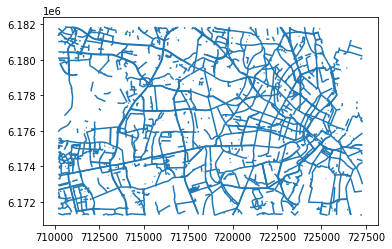

In [4]:
# TODO: Plot
osm_simplified_edges.plot()

<AxesSubplot:>

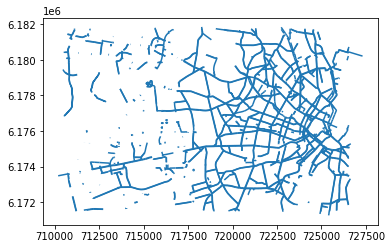

In [18]:
# TODO: Plot
ref_simplified_edges.plot()

<AxesSubplot:>

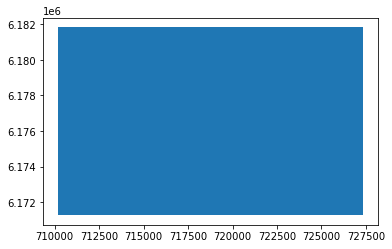

In [23]:
# TODO: Plot
grid.plot()

**Joining grid cell id to network elements and counting features in each grid:**

In [36]:
# Join grid ids to data 

osm_edges_s_j = gpd.overlay(osm_simplified_edges, grid, how ='intersection')
osm_edges_j = gpd.overlay(osm_edges, grid, how='intersection')

osm_nodes_s_j = gpd.overlay(osm_simplified_nodes, grid, how ='intersection')
osm_nodes_j = gpd.overlay(osm_nodes, grid, how='intersection')

# Count features in each grid cell
all_data = [osm_edges_j,  osm_nodes_j, osm_edges_s_j, osm_nodes_s_j]
labels = ['osm_edges','osm_nodes','osm_simplified_edges','osm_simplified_nodes']

for data, label in zip(all_data, labels):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

ref_edges_s_j = gpd.overlay(ref_simplified_edges, grid, how ='intersection')
ref_edges_j = gpd.overlay(ref_edges, grid, how='intersection')

ref_nodes_s_j = gpd.overlay(ref_simplified_nodes, grid, how ='intersection')
ref_nodes_j = gpd.overlay(ref_nodes, grid, how='intersection')

# Count features in each grid cell
all_data = [ref_edges_j,  ref_nodes_j, ref_edges_s_j, ref_nodes_s_j]
labels = ['ref_edges','ref_nodes','ref_simplified_edges','ref_simplified_nodes']

for data, label in zip(all_data, labels):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

## General Comparison of Network Structure

Total and per grid cell:
- Network length
- Number of nodes/intersections
- Connected components
- Length of different types of infrastructure

In [42]:
osm_edge_percent_diff = (len(osm_edges) - len(osm_simplified_edges)) / len(osm_edges)*100
osm_node_percent_diff = (len(osm_nodes) - len(osm_simplified_nodes)) / len(osm_nodes)*100
print(f'Simplifying the OSM network decreased the number of edges with {osm_edge_percent_diff:.1f}%')
print(f'Simplifying the OSM network decreased the number of nodes with {osm_node_percent_diff:.1f}%')

ref_edge_percent_diff = (len(ref_edges) - len(ref_simplified_edges)) / len(ref_edges)*100
ref_node_percent_diff = (len(ref_nodes) - len(ref_simplified_nodes)) / len(ref_nodes)*100
print(f'Simplifying the reference network decreased the number of edges with {ref_edge_percent_diff:.1f}%')
print(f'Simplifying the reference network decreased the number of nodes with {ref_node_percent_diff:.1f}%')

Simplifying the OSM network decreased the number of edges with 82.7%
Simplifying the OSM network decreased the number of nodes with 84.8%
Simplifying the reference network decreased the number of edges with 60.2%
Simplifying the reference network decreased the number of nodes with 63.5%


In [ ]:
# TODO: Compare network length

# total and per grid cell (per grid cell as length or network density?)

In [ ]:
# TODO: Compare number of nodes AND intersections

# total and per grid cell

In [46]:
osm_alpha, osm_beta, osm_gamma = ef.compute_alpha_beta_gamma(osm_simplified_nodes, osm_simplified_edges)

print(f'Alpha for the simplified OSM network is: {osm_alpha:.2f}')
print(f'Beta for the simplified OSM network is: {osm_beta:.2f}')
print(f'Gamma for the simplified OSM network is: {osm_gamma:.2f}')

ref_alpha, ref_beta, ref_gamma = ef.compute_alpha_beta_gamma(ref_simplified_nodes, ref_simplified_edges)

print(f'Alpha for the simplified reference network is: {ref_alpha:.2f}')
print(f'Beta for the simplified reference network is: {ref_beta:.2f}')
print(f'Gamma for the simplified reference network is: {ref_gamma:.2f}')

Alpha for the simplified OSM network is: 0.08
Beta for the simplified OSM network is: 1.16
Gamma for the simplified OSM network is: 0.39
Alpha for the simplified reference network is: 0.08
Beta for the simplified reference network is: 1.15
Gamma for the simplified reference network is: 0.38


In [ ]:
# TODO Compare network density

# Entire study area
edge_density, node_density, dangling_node_density = ef.compute_network_density((simplified_edges, simplified_nodes),grid.unary_union.area, return_dangling_nodes=True)

print(edge_density)
print(node_density)
print(dangling_node_density)

# Per grid cell
results_dict = {}
area = grid.loc[0,'geometry'].area
data = (s_edges_join, s_nodes_join)
[ef.run_grid_analysis(grid_id, data, results_dict, ef.compute_network_density, area) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'edge_density',1:'node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='edge_density', legend=True)
grid.plot(column='node_density', legend=True)

In [ ]:
# TODO: Compare number of connected components

# TODO: Compare plots of unconnected issues!

components = ef.return_components(osm_simplified_graph)
print(f'The network in the study area consists of {len(components)} unconnected components.')

components_plot = ef.plot_components(components)

issues, component_edges = ef.find_adjacent_components(components=components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

simplified_edges.plot(ax=ax, color='grey')
issues.plot(ax=ax, color='red', linewidth=2)

# TODO: Fix plot - plot with uconnected components as well

In [ ]:
# TODO: Compare number of dangling nodes

# total and per grid cell

# Compute number of dangling nodes - and plot them
dangling_nodes = ef.get_dangling_nodes(simplified_edges, simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
simplified_nodes.plot(ax=ax, color='black', markersize=5)
dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

In [ ]:
# TODO: Compare snapping issues
buffer_dist = 1
snapping_issues = ef.find_network_gaps(nodes,edges, buffer_dist)

print(f'There are {len(snapping_issues)} locations where a node is placed within {buffer_dist} meters of another node without sharing an edge.')

fig, axes = plt.subplots(ncols=1 ,nrows=len(snapping_issues), figsize=(10,10))

axes = axes.flatten()

for s in range(len(snapping_issues)):
    subset = nodes.loc[nodes.node_id.isin(snapping_issues[s])]
    subset.plot(ax=axes[s])

    cx.add_basemap(
        ax=axes[s], 
        crs=simplified_edges.crs, 
        source=cx.providers.CyclOSM,
    )


## Feature Matching

- Matched and non-matched edges - total and per grid cell (count or length?)
- Comparison of matched edges - do they aggree on core attributes?


What are core attributes? I am thinking whether it is lane/track? One or two-way - but how to account for differing digitising methods? Maybe protected/unprotected is enough?

For this - needs to be translated in the data attribute values

In [ ]:
# Matched and non-matched edges - total and per grid cell

In [47]:
# Define attributes to be compared for matches
type(True) == bool

True

## Feasibility for Routing
- Can you use for routing?
- Differing shortest paths?